In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Download required images from BING

In [3]:
!pip install bing-image-downloader

We are classifying 4 kinds of breeds: Cockers, Beagles, Retrievers & Labs

In [4]:
from bing_image_downloader import downloader
for q in ["Cocker Spaniel","Beagle","Golden Retriever","Labrador"]:
    downloader.download(q, limit=100, output_dir='dog_breeds', adult_filter_off=True, force_replace=False, timeout=5)

[%] Downloading Images to /notebooks/clean/dog_breeds/Cocker Spaniel


[!!]Indexing page: 1

[%] Indexed 100 Images on Page 1.


[%] Downloading Image #1 from https://barkpost.com/wp-content/uploads/2019/07/english-cocker-spaniel-energy.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://petpress.net/wp-content/uploads/2019/11/volker_li_74670550_154395372623767_5542363227156873434_n.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://upload.wikimedia.org/wikipedia/commons/f/fe/Cocker_spaniel_angielski_zlotyy.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.pets4homes.co.uk/images/classifieds/2020/10/26/2938173/large/kc-registered-true-working-cocker-spaniel-puppies-5f9697e9ca983.jpg
[!] Issue getting: https://www.pets4homes.co.uk/images/classifieds/2020/10/26/2938173/large/kc-registered-true-working-cocker-spaniel-puppies-5f9697e9ca983.jpg
[!] Error:: HTTP Error 404: Not Found
[%] Downloading Image #4 from https://www.urbanpawsuk.com/wp-con

In [5]:
#animal_types = 'Dog','Cat'
path = Path('dog_breeds')

In [6]:
fns = get_image_files(path)
fns

(#402) [Path('dog_breeds/Labrador/Image_32.jpg'),Path('dog_breeds/Labrador/Image_100.jpg'),Path('dog_breeds/Labrador/Image_76.png'),Path('dog_breeds/Labrador/Image_93.jpg'),Path('dog_breeds/Labrador/Image_61.jpg'),Path('dog_breeds/Labrador/Image_38.jpeg'),Path('dog_breeds/Labrador/Image_30.jpg'),Path('dog_breeds/Labrador/Image_43.jpg'),Path('dog_breeds/Labrador/Image_73.jpg'),Path('dog_breeds/Labrador/Image_29.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [9]:
dog_breeds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = dog_breeds.dataloaders(path)

# Show validation batch samples

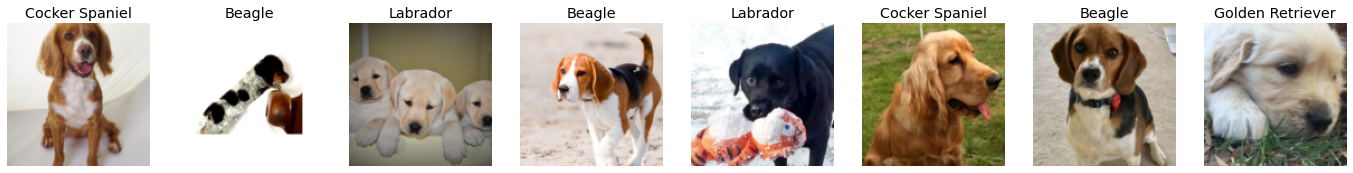

In [11]:
dls.valid.show_batch(max_n=8, nrows=1)

# Show squished images

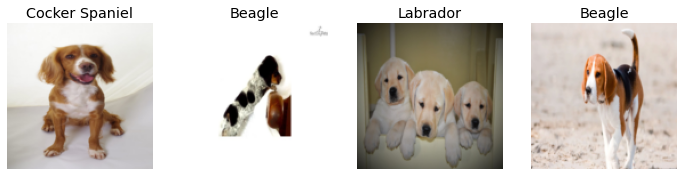

In [12]:
dog_breeds = dog_breeds.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dog_breeds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Padded images

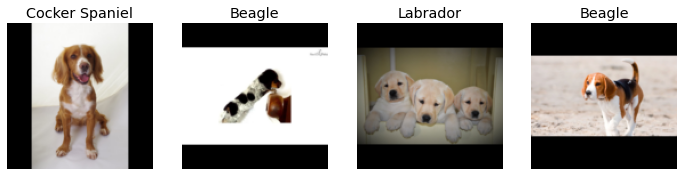

In [13]:
dog_breeds = dog_breeds.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dog_breeds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Image transforms

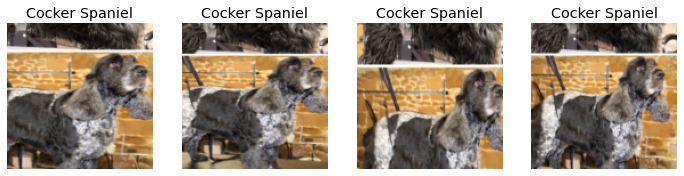

In [14]:
dog_breeds = dog_breeds.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dog_breeds.dataloaders(path,bs=5)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation

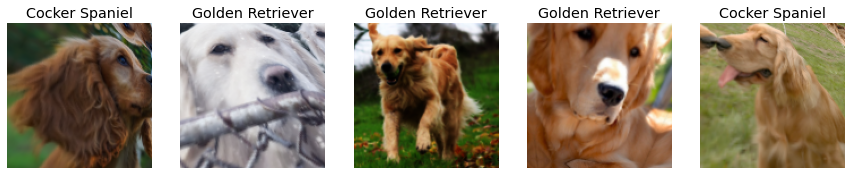

In [15]:
dog_breeds = dog_breeds.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dog_breeds.dataloaders(path,bs=5)
dls.train.show_batch(max_n=5, nrows=1, unique=False)

## Training Your Model, and Using It to Clean Your Data

In [16]:
dog_breeds = dog_breeds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dog_breeds.dataloaders(path)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.205854,0.849107,0.350000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.879979,0.475260,0.187500,00:10
1,0.666061,0.346166,0.100000,00:09
2,0.523398,0.369284,0.137500,00:09
3,0.421753,0.378256,0.100000,00:10


# Confusion Matrix

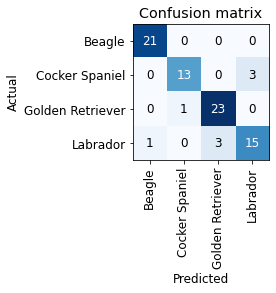

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Losses

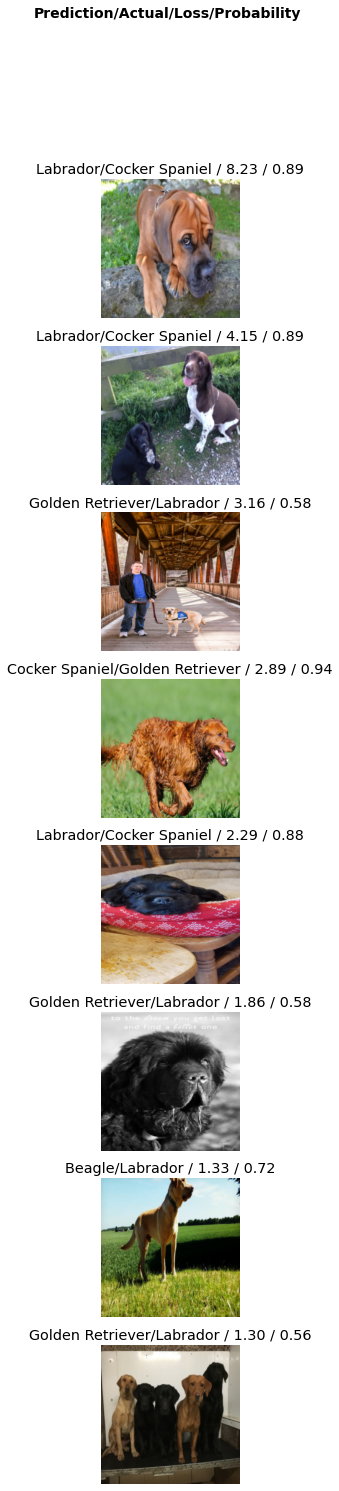

In [19]:
interp.plot_top_losses(8, nrows=8)

# Clean up bad images

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

## Predict on new images

In [ ]:
learn_inf.predict('images/H.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/A.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your pet!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 